In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import copy
import random
import torch
import pandas as pd
import akshare as ak
import tqdm
from sklearn.model_selection import GridSearchCV, PredefinedSplit
import plotly.express as px

c:\Users\26954\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True  # 保证卷积操作也固定（可选）
    torch.backends.cudnn.benchmark = False     # 可选，稳定性优先

In [ ]:
def assign_deciles(df, factor):
    try:
        df = df.copy()
        # 确保当前月份样本足够，否则直接标记为 NaN
        if len(df) >= 10:
            df['decile'] = pd.qcut(df[factor], 10, labels=False, duplicates='drop') + 1
        else:
            df['decile'] = np.nan
        return df
    except IndexError:
        pass

In [ ]:
def cal_sharpe_ratio(monthly_returns):
    mean_r = monthly_returns.mean()
    std_r = monthly_returns.std(ddof=1)
    IR_monthly = mean_r / std_r
    sharpe = np.sqrt(12) * IR_monthly
    return sharpe

In [ ]:
def cal_max_drawdown(cum_returns):
    running_max = cum_returns.cummax()
    drawdowns = (cum_returns - running_max) / running_max
    return drawdowns.min()

In [ ]:
longonly_filter1 = ['tpi_21',
                    'gross_profit_to_asset_yoy_chg',
                    'std_unexpected_net_profit_using_ar',
                    'buffett_zscore',
                    'amount_21',
                    'idios_vol_ff3_21',
                    'std_unexpected_net_profit',
                    'mcap',
                    'aqr_profitability',
                    'sell_exp_to_revenue_ttm']

longshort_filter1 = ['net_cash_flow_to_asset_yoy_chg',
                     'inv_yoy_chg_on_asset',
                     'current_ratio_mra',
                     'liquidity_shock_21_252',
                     'idios_vol_capm_252',
                     'net_profit_yoy_pct_chg_acc',
                     'current_ratio_yoy_chg',
                     'std_unexpected_net_profit_using_ar',
                     'inventories_yoy_pct_chg',
                     'current_operating_liabilities_yoy_chg_to_total_asset',
                     'illiq_252',
                     'net_profit_to_asset_yoy_chg_acc',
                     'capital_gain_overhang_252',
                     'sga_to_revenue_mra_yoy_chg',
                     'std_unexpected_revenue_with_drift',
                     'adminexp_to_total_mktcap_ttm',
                     'gross_profit_to_asset_yoy_chg',
                     'total_skewness_252',
                     'total_mv',
                     'tax_yoy_chg_to_asset',
                     'std_unexpected_net_profit_with_drift',
                     'sell_exp_to_revenue_ttm',
                     'buffett_zscore',
                     'abnormal_turnover_21',
                     'earnings_announcement_return1',
                     'abnormal_accruals_basic_jones',
                     'amount_21',
                     'idios_vol_ff3_21',
                     'intraday_momentum_21']

longonly_filter2 = ['firm_age',
                    'west_eps_fy1_chg_1m',
                    'ohlson_score',
                    'adminexp_to_total_mktcap_ttm',
                    'long_term_debt_ratio_yoy_chg',
                    'current_ratio_mra',
                    'illiq_252',
                    'mcap',
                    'retained_earnings_to_asset',
                    'gross_profit_margin_ttm',
                    'sellexp_to_total_mktcap_ttm',
                    'current_liab_mra']

longshort_filter2 = ['current_operating_liabilities_yoy_chg_to_total_asset',
                     'adminexp_to_total_mktcap_ttm',
                     'gross_profit_to_asset_yoy_chg',
                     'illiq_252',
                     'std_unexpected_net_profit_using_ar',
                     'current_ratio_mra',
                     'std_unexpected_net_profit',
                     'current_ratio_yoy_chg',
                     'mcap',
                     'sell_exp_to_revenue_ttm',
                     'buffett_zscore',
                     'idios_vol_ff3_21',
                     'west_eps_fy1_chg_1m']


for i in [longonly_filter1,longshort_filter1,longonly_filter2,longshort_filter2]:
    print(len(i))

10
29
12
13


In [89]:
index_zh_a_hist_df = ak.index_zh_a_hist(symbol="000905", period="monthly", start_date="19700101", end_date="22220101")
index_zh_a_hist_df.rename({'日期':'date','涨跌幅':'zz500_return'},axis=1,inplace=True)
index_zh_a_hist_df['date'] = pd.to_datetime(index_zh_a_hist_df['date'])
index_zh_a_hist_df['date'] = index_zh_a_hist_df['date'] + pd.offsets.MonthEnd(0)
index_zh_a_hist_df['zz500_return'] = index_zh_a_hist_df['zz500_return']*0.01

In [ ]:
def assign_deciles1(df, factor):
    try:
        df = df.copy()
        # 确保当前月份样本足够，否则直接标记为 NaN
        if len(df) >= 10:
            df['decile'] = pd.qcut(df[factor], 10, labels=False, duplicates='drop') + 1
        else:
            df['decile'] = np.nan
        return df['decile']
    except IndexError:
        pass

# 定义训练集，验证集和测试集的时间区间
train_start = pd.to_datetime('2007-02-01')
train_end = pd.to_datetime('2014-01-31')
valid_start = pd.to_datetime('2014-02-01')
valid_end = pd.to_datetime('2016-12-31')
test_start = pd.to_datetime('2017-01-01')
test_end = pd.to_datetime('2024-05-31')

data = pd.read_parquet('datasets.parquet', engine='pyarrow')
row_df = data[['date','stock','monthly_return']].copy()

multi_factor_df1 = pd.read_csv('multi_factor_df1.csv')
multi_factor_df2 = pd.read_csv('multi_factor_df2.csv')
multi_factor_df3 = pd.read_csv('multi_factor_df3.csv')
multi_factor_df4 = pd.read_csv('multi_factor_df4.csv')
df_map = {
    tuple(longonly_filter1):   multi_factor_df1,
    tuple(longshort_filter1):  multi_factor_df2,
    tuple(longonly_filter2):   multi_factor_df3,
    tuple(longshort_filter2):  multi_factor_df4,
}
# 在此处制定特征列表即可
input_factors = longonly_filter1
key = tuple(input_factors)
if key not in df_map:
    raise ValueError(f"未知的 input_factors：{input_factors!r}")
draw_df = df_map[key].copy()
draw_df['date'] = pd.to_datetime(draw_df['date']) # 以防万一报错
for factor in tqdm.tqdm(input_factors):
    row_df[factor] = data.groupby('date').apply(assign_deciles1, factor=factor).reset_index(drop=True)

df = row_df.fillna(-1)
index_zh_a_hist_df['lag_zz500_return'] = index_zh_a_hist_df['zz500_return'].shift(-1)
df = pd.merge(df,index_zh_a_hist_df[['date','lag_zz500_return']],on='date',how='left')
df['excess_return'] = df['monthly_return']-df['lag_zz500_return']
train_df = df[df['date'].between(train_start,train_end)].copy()
valid_df = df[df['date'].between(valid_start,valid_end)].copy()
test_df = df[df['date'].between(test_start,test_end)].copy()

X_train = train_df[input_factors]
y_train = train_df['monthly_return']

X_valid = valid_df[input_factors]
y_valid = valid_df['monthly_return']

X_test  = test_df[input_factors]
y_test  = test_df['monthly_return']

print("训练集样本数:", X_train.shape[0])
print("验证集样本数:", X_valid.shape[0])
print("测试集样本数:", X_test.shape[0])

# 合并训练集和验证集用于调参
X_train_valid = np.vstack([X_train, X_valid])
y_train_valid = np.concatenate([y_train, y_valid])
# 构造 PredefinedSplit：训练样本标记为 -1，验证样本标记为 0
train_valid_fold = np.concatenate([-1 * np.ones(len(X_train)), np.zeros(len(X_valid))])
ps = PredefinedSplit(train_valid_fold)

100%|██████████| 10/10 [00:02<00:00,  4.81it/s]

训练集样本数: 40060
验证集样本数: 16032
测试集样本数: 43364


In [ ]:
# 初始化列名
nn_columns=[
    'name', 'arch', 'alpha', 'lr', 'batch',
    'ic', 'pval',
    'NN_hedge_sharpe', 'NN_hedge_max_dd', 'NN_hedge_returns', 'NN_hedge_cumulative_return',
    'NN_long_sharpe',  'NN_long_max_dd',  'NN_long_returns',  'NN_long_cumulative_return',
    'NN_short_sharpe', 'NN_short_max_dd', 'NN_short_returns', 'NN_short_cumulative_return'
]
nn_results_df = pd.DataFrame(columns=nn_columns)

In [ ]:
def draw_pnl(y_pred):
    global draw_df
    test_df['pred_return'] = y_pred
    portfolio_df = test_df.groupby('date').apply(assign_deciles, factor='pred_return').reset_index(drop=True)
    monthly_returns = portfolio_df.groupby(['date', 'decile'])['monthly_return'].mean().reset_index()
    decile1 = monthly_returns[monthly_returns['decile'] == 1].rename(columns={'monthly_return': 'return_decile1'})
    decile10 = monthly_returns[monthly_returns['decile'] == 10].rename(columns={'monthly_return': 'return_decile10'})
    merged_deciles = pd.merge(decile10, decile1, on='date', how='inner')
    merged_deciles['HL_return'] = (merged_deciles['return_decile10'] - merged_deciles['return_decile1'])
    merged_deciles['H_return'] = (merged_deciles['return_decile10'])
    merged_deciles['L_return'] = (-merged_deciles['return_decile1'])
    merged_deciles = merged_deciles.sort_values(by='date')
    merged_deciles['NN_hedge'] = (1 + merged_deciles['HL_return']).cumprod() - 1
    merged_deciles['NN_long'] = (1 + merged_deciles['H_return']).cumprod() - 1
    merged_deciles['NN_short'] = (1 + merged_deciles['L_return']).cumprod() - 1
    merged_deciles = pd.merge(merged_deciles,index_zh_a_hist_df[['date','zz500_return']],how='left',on='date')
    merged_deciles['zz500_return'] = (1 + merged_deciles['zz500_return']).cumprod() - 1

    draw_df.drop('zz500_return',axis=1,inplace=True)
    draw_df = draw_df[draw_df['date'].between(test_start,test_end)]
    draw_df['multi_factor'] = (1+draw_df['multi_factor']).pct_change()
    draw_df['multi_factor'] = (1 + draw_df['multi_factor']).cumprod() - 1
    # draw_df['date'] = pd.to_datetime(draw_df['date'])
    merged_deciles['date'] = pd.to_datetime(merged_deciles['date'])
    draw_df_nn = pd.merge(draw_df,merged_deciles[['date','NN_hedge','NN_long','NN_short']],on='date',how='left')

    fig = px.line(
        draw_df_nn,
        x='date',
        y=['multi_factor','NN_hedge','NN_long','NN_short','zz500_return'],
        labels={
            'value': 'Cumulative Return',
            'variable': 'Strategy'
        },
        title='Cumulative Return Comparison: HL vs. ZZ500',
        width=700,       # 宽度：建议 800～1200
        height=400       # 高度：建议 300～600
    )

    # 添加三个阶段的背景色块
    # fig.add_vrect(x0="2007-02-01", x1="2014-01-31",
    #             fillcolor="LightBlue", opacity=0.3, layer="below", line_width=0,
    #             annotation_text="Train", annotation_position="top left")

    # fig.add_vrect(x0="2014-02-01", x1="2016-12-31",
    #             fillcolor="LightGreen", opacity=0.3, layer="below", line_width=0,
    #             annotation_text="Validation", annotation_position="top left")

    fig.add_vrect(x0="2017-01-01", x1="2024-05-31",
                fillcolor="LightCoral", opacity=0.3, layer="below", line_width=0,
                annotation_text="Test", annotation_position="top left")

    fig.update_layout(
        xaxis_title='Date',
        yaxis_title='Cumulative Return',
        template='plotly_white',
        legend_title='',
    )
    fig.show()

    ic, p_value = spearmanr(test_df['pred_return'], test_df['excess_return'])
    print("Information Coefficient (Spearman rho):", ic)
    print("P-value:", p_value)
    # 计算夏普和最大回撤
    sharpe = cal_sharpe_ratio((draw_df_nn['NN_hedge']+1).pct_change())
    max_dd = cal_max_drawdown((draw_df_nn['NN_hedge']+1))
    returns = (draw_df_nn['NN_hedge']+1).pct_change().mean() * 12
    
    nn_results_df.loc[len(nn_results_df) - 1, ['NN_hedge_sharpe', 'NN_hedge_max_dd', 'NN_hedge_returns']] = [sharpe, max_dd, returns]
    print(f'NN_hedge sharpe: {sharpe}, max_drawdown: {max_dd}, annual return: {returns}')
    
    sharpe = cal_sharpe_ratio((draw_df_nn['NN_long']+1).pct_change())
    max_dd = cal_max_drawdown((draw_df_nn['NN_long']+1))
    returns = (draw_df_nn['NN_long']+1).pct_change().mean() * 12
    nn_results_df.loc[len(nn_results_df) - 1, ['NN_long_sharpe',  'NN_long_max_dd',  'NN_long_returns']] = [sharpe, max_dd, returns]
    print(f'NN_long sharpe: {sharpe}, max_drawdown: {max_dd}, annual return: {returns}')   

    sharpe = cal_sharpe_ratio((draw_df_nn['NN_short']+1).pct_change())
    max_dd = cal_max_drawdown((draw_df_nn['NN_short']+1))
    returns = (draw_df_nn['NN_short']+1).pct_change().mean() * 12
    nn_results_df.loc[len(nn_results_df) - 1, ['NN_short_sharpe', 'NN_short_max_dd', 'NN_short_returns']] = [sharpe, max_dd, returns]
    print(f'NN_short sharpe: {sharpe}, max_drawdown: {max_dd}, annual return: {returns}')     

    # 记录cumulative return（draw_df_nn 最后一行的三个策略值）
    last_row_idx = len(nn_results_df) - 1
    for strat in ['NN_hedge', 'NN_long', 'NN_short']:
        colname = f"{strat}_cumulative_return"
        value = draw_df_nn[strat].iloc[-1]
        nn_results_df.loc[last_row_idx, colname] = value

    return

In [ ]:
# === 1. Spearman IC 近似损失函数（可微） ===
class SpearmanApproxLoss(nn.Module):
    def __init__(self):
        super(SpearmanApproxLoss, self).__init__()

    def forward(self, y_pred, y_true):
        y_pred_std = (y_pred - y_pred.mean()) / y_pred.std()
        y_true_std = (y_true - y_true.mean()) / y_true.std()
        corr = torch.mean(y_pred_std * y_true_std)
        return -corr  # maximize IC

# === 2. 简单 NN 模型结构 ===
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_layers):
        super(SimpleNN, self).__init__()
        layers = []
        last_dim = input_dim
        for h in hidden_layers:
            layers.append(nn.Linear(last_dim, h))
            layers.append(nn.ReLU())
            last_dim = h
        layers.append(nn.Linear(last_dim, 1))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# === 3. 准备数据 ===
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(train_df['excess_return'].values, dtype=torch.float32).view(-1, 1)

X_valid_tensor = torch.tensor(X_valid.values, dtype=torch.float32)
y_valid_tensor = torch.tensor(valid_df['excess_return'].values, dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(test_df['excess_return'].values, dtype=torch.float32).view(-1, 1)

# train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
# train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

In [ ]:
# === 4. 测试一组参数，输出评测结果 ===
def run_experiment(name, hidden_layers, alpha, lr, batch_size, max_epochs=50, patience=10):
    print(f"\n🚀 Running experiment: {name}, hidden={hidden_layers}, alpha={alpha}, lr={lr}, batch={batch_size}")
    set_seed(42)  # 或你想要的任意整数
    # 给结果表添加一行空数据，并添加参数信息
    nn_results_df.loc[len(nn_results_df)] = [None] * len(nn_columns)
    nn_results_df.loc[len(nn_results_df) - 1, ['name', 'arch', 'alpha', 'lr', 'batch']] = [name, str(hidden_layers), alpha, lr, batch_size]

    model = SimpleNN(input_dim=X_train.shape[1], hidden_layers=hidden_layers)
    criterion = SpearmanApproxLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=alpha)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    early_stop_counter = 0
    best_model_state = None

    for epoch in range(max_epochs):
        model.train()
        batch_losses = []
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            val_pred = model(X_valid_tensor)
            val_loss = criterion(val_pred, y_valid_tensor).item()

        train_losses.append(np.mean(batch_losses))
        val_losses.append(val_loss)

        if val_loss < best_val_loss - 1e-4:
            best_val_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print(f"⛔ Early stopped at epoch {epoch+1}")
                break

    if best_model_state:
        model.load_state_dict(best_model_state)

    plt.figure(figsize=(6, 5))
    plt.plot(train_losses, label='Train -IC')
    plt.plot(val_losses, label='Val -IC')
    plt.xlabel('Epoch')
    plt.ylabel('-Spearman (IC)')
    plt.title(f'IC-Based Learning Curve: {name}')
    plt.legend()
    plt.grid(True)
    plt.show()

    model.eval()
    y_pred_test = model(X_test_tensor).detach().numpy().flatten()
    test_df['pred_return'] = y_pred_test
    ic, pval = spearmanr(test_df['pred_return'], test_df['excess_return'])
    print("📊 Test IC:", round(ic, 4), ", p-value:", round(pval, 4))
    nn_results_df.loc[len(nn_results_df) - 1, ['ic', 'pval']] = [ic, pval]
    draw_pnl(y_pred_test)
    return

In [ ]:
new_architectures = {
    # ✅ 基准组：推荐保留用于对比
    'WIDE_32_32':    ((32, 32), 1e-4, 0.001, 1024),

    # 🔹【隐藏层】结构变宽/变深/变浅
    'WIDE_64_64':    ((64, 64), 1e-4, 0.001, 1024),
    'DEEP_64_64_32': ((64, 64, 32), 1e-4, 0.001, 1024),
    'SHALLOW_32':    ((32,), 1e-4, 0.001, 1024),

    # 🔹【正则化】变大和变小
    'REG_WEAK':      ((32, 32), 1e-5, 0.001, 1024),
    'REG_STRONG':    ((32, 32), 1e-3, 0.001, 1024),

    # 🔹【学习率】更快/更慢
    'LR_FAST':       ((32, 32), 1e-4, 0.005, 1024),
    'LR_SLOW':       ((32, 32), 1e-4, 0.0001, 1024),

    # 🔹【Batch Size】更大/更小
    'BATCH_4096':    ((32, 32), 1e-4, 0.001, 4096),
    'BATCH_512':     ((32, 32), 1e-4, 0.001, 2024),
    'BATCH_512':     ((32, 32), 1e-4, 0.001, 512),

    # 🔹【组合试验】更强表达 + 更小正则 + 更小batch
    'EXPRESSIVE_LOWREG': ((64, 32), 1e-5, 0.001, 512),

    # 🔹【组合试验】宽浅 + 强正则 + 更大 batch
    'WIDE_STRONGREG_BIGBATCH': ((128,), 1e-3, 0.001, 2048),
}


🚀 Running experiment: WIDE_32_32, hidden=(32, 32), alpha=0.0001, lr=0.001, batch=1024
⛔ Early stopped at epoch 22


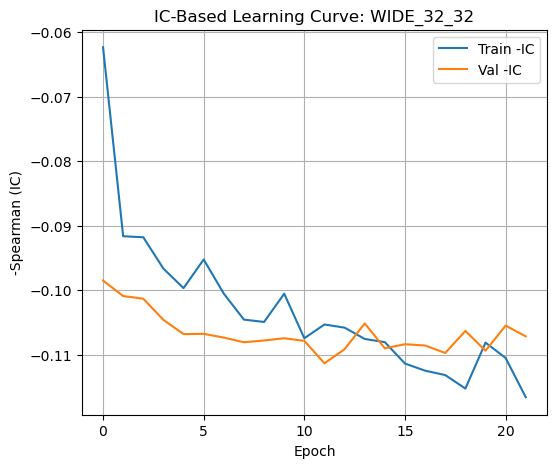

📊 Test IC: 0.0665 , p-value: 0.0


C:\Users\26954\AppData\Local\Temp\ipykernel_25644\1422460871.py:3: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

c:\Users\26954\anaconda3\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



Information Coefficient (Spearman rho): 0.06648440843605977
P-value: 1.1119068790609618e-43
NN_hedge sharpe: 1.01470280895191, max_drawdown: -0.23834723258807666, annual return: 0.15945123108920728
NN_long sharpe: 0.27876500737289595, max_drawdown: -0.316182042560528, annual return: 0.0539089664582163
NN_short sharpe: 0.4310909283142316, max_drawdown: -0.5544556602803205, annual return: 0.10554226463099091

🚀 Running experiment: WIDE_64_64, hidden=(64, 64), alpha=0.0001, lr=0.001, batch=1024
⛔ Early stopped at epoch 17


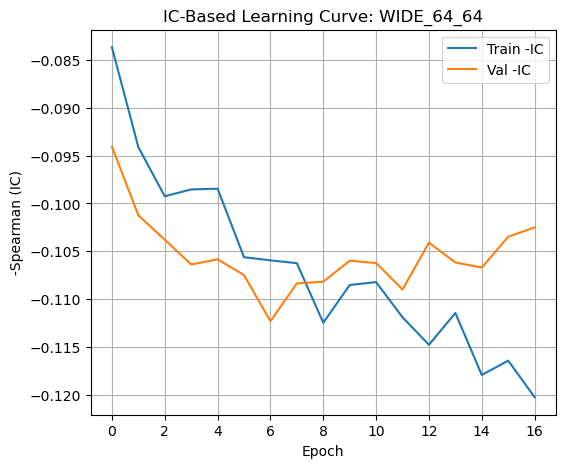

📊 Test IC: 0.064 , p-value: 0.0


C:\Users\26954\AppData\Local\Temp\ipykernel_25644\1422460871.py:3: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

c:\Users\26954\anaconda3\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



Information Coefficient (Spearman rho): 0.06398973701194534
P-value: 1.3816609055238373e-40
NN_hedge sharpe: 1.267570869802951, max_drawdown: -0.16864793148739507, annual return: 0.18520612780908932
NN_long sharpe: 0.33127285635426296, max_drawdown: -0.2945402868449445, annual return: 0.06144561633555333
NN_short sharpe: 0.5199730546999773, max_drawdown: -0.46671530871733474, annual return: 0.1237605114735357

🚀 Running experiment: DEEP_64_64_32, hidden=(64, 64, 32), alpha=0.0001, lr=0.001, batch=1024
⛔ Early stopped at epoch 20


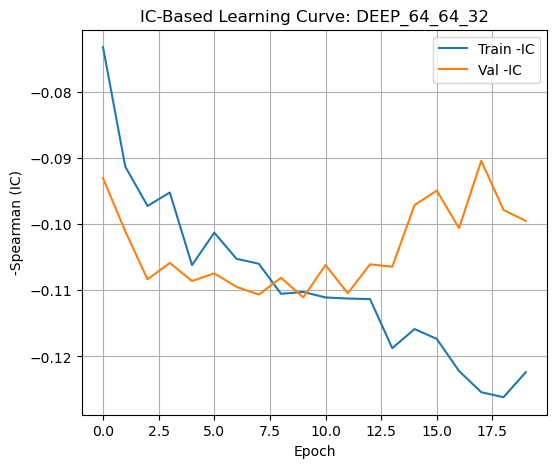

📊 Test IC: 0.0635 , p-value: 0.0


C:\Users\26954\AppData\Local\Temp\ipykernel_25644\1422460871.py:3: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

c:\Users\26954\anaconda3\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



Information Coefficient (Spearman rho): 0.0635317770918185
P-value: 4.961573675545371e-40
NN_hedge sharpe: 1.3459961944421055, max_drawdown: -0.15035192155674726, annual return: 0.1932876638801136
NN_long sharpe: 0.3492412984099736, max_drawdown: -0.2866109653106693, annual return: 0.06840041060475345
NN_short sharpe: 0.5365208361864516, max_drawdown: -0.4400115785924643, annual return: 0.12488725327536035

🚀 Running experiment: SHALLOW_32, hidden=(32,), alpha=0.0001, lr=0.001, batch=1024
⛔ Early stopped at epoch 34


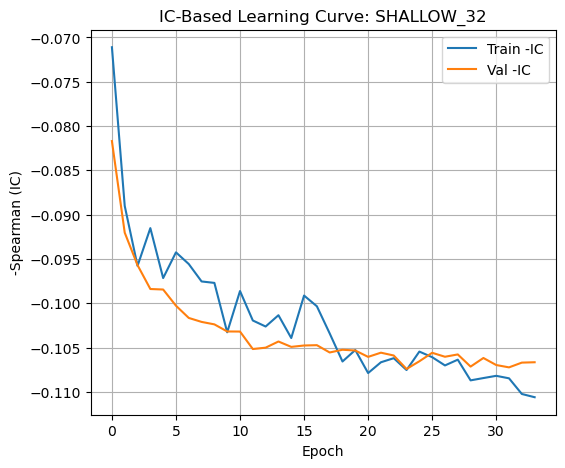

📊 Test IC: 0.0608 , p-value: 0.0


C:\Users\26954\AppData\Local\Temp\ipykernel_25644\1422460871.py:3: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

c:\Users\26954\anaconda3\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



Information Coefficient (Spearman rho): 0.06080867042881581
P-value: 8.221764719219653e-37
NN_hedge sharpe: 1.0653578146745017, max_drawdown: -0.18956071016841072, annual return: 0.1650808396906883
NN_long sharpe: 0.27736017959434794, max_drawdown: -0.29872591540299165, annual return: 0.05062832410660158
NN_short sharpe: 0.477392805702757, max_drawdown: -0.5427379270414031, annual return: 0.11445251558408667

🚀 Running experiment: REG_WEAK, hidden=(32, 32), alpha=1e-05, lr=0.001, batch=1024
⛔ Early stopped at epoch 22


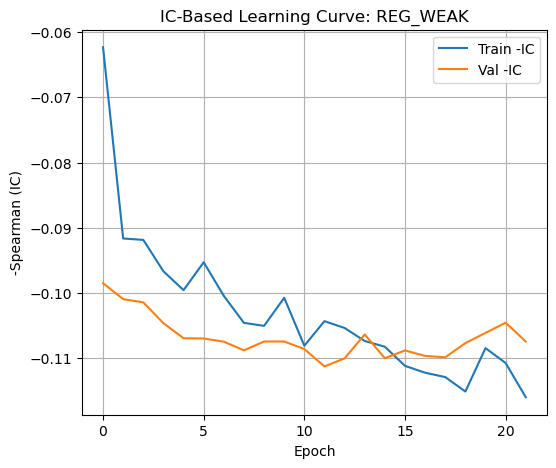

📊 Test IC: 0.0673 , p-value: 0.0


C:\Users\26954\AppData\Local\Temp\ipykernel_25644\1422460871.py:3: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

c:\Users\26954\anaconda3\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



Information Coefficient (Spearman rho): 0.06729315691609167
P-value: 1.0412583937380395e-44
NN_hedge sharpe: 0.9938265408028153, max_drawdown: -0.2589079991000088, annual return: 0.15974483906491502
NN_long sharpe: 0.2778171480724323, max_drawdown: -0.31401956598166203, annual return: 0.053839394132557936
NN_short sharpe: 0.4357964403399726, max_drawdown: -0.5564704843238311, annual return: 0.10590544493235698

🚀 Running experiment: REG_STRONG, hidden=(32, 32), alpha=0.001, lr=0.001, batch=1024
⛔ Early stopped at epoch 22


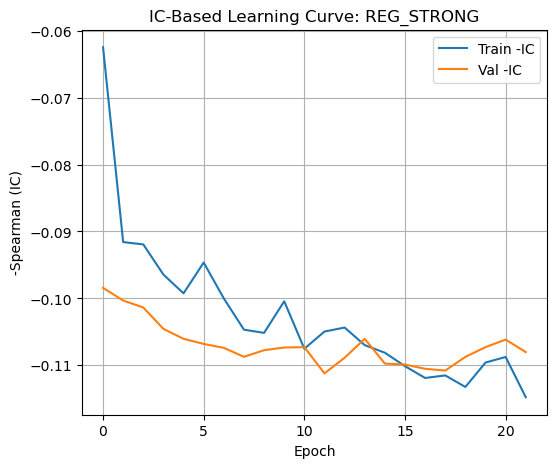

📊 Test IC: 0.0683 , p-value: 0.0


C:\Users\26954\AppData\Local\Temp\ipykernel_25644\1422460871.py:3: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

c:\Users\26954\anaconda3\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



Information Coefficient (Spearman rho): 0.0683406938850704
P-value: 4.644121743674802e-46
NN_hedge sharpe: 1.06938647151082, max_drawdown: -0.23335223444791348, annual return: 0.16770181230234957
NN_long sharpe: 0.3388920252147186, max_drawdown: -0.30764973412067753, annual return: 0.0635430954799546
NN_short sharpe: 0.4314323893872168, max_drawdown: -0.5604735244421747, annual return: 0.10415871682239494

🚀 Running experiment: LR_FAST, hidden=(32, 32), alpha=0.0001, lr=0.005, batch=1024
⛔ Early stopped at epoch 18


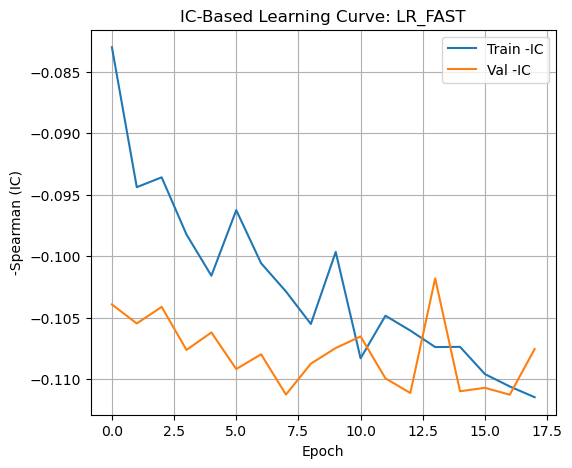

📊 Test IC: 0.0643 , p-value: 0.0


C:\Users\26954\AppData\Local\Temp\ipykernel_25644\1422460871.py:3: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

c:\Users\26954\anaconda3\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



Information Coefficient (Spearman rho): 0.06429402851314739
P-value: 5.878788066895075e-41
NN_hedge sharpe: 1.0966747356602435, max_drawdown: -0.18438705227708793, annual return: 0.1671101917128392
NN_long sharpe: 0.27612579213693633, max_drawdown: -0.29902754627898537, annual return: 0.05294754694168885
NN_short sharpe: 0.46778985467402756, max_drawdown: -0.5389968674429004, annual return: 0.1141626447711504

🚀 Running experiment: LR_SLOW, hidden=(32, 32), alpha=0.0001, lr=0.0001, batch=1024


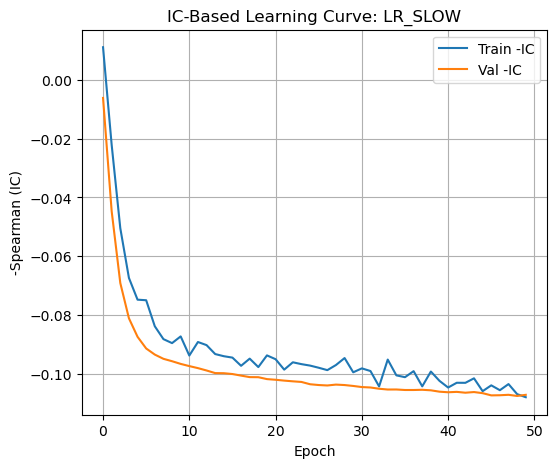

📊 Test IC: 0.0657 , p-value: 0.0


C:\Users\26954\AppData\Local\Temp\ipykernel_25644\1422460871.py:3: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

c:\Users\26954\anaconda3\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



Information Coefficient (Spearman rho): 0.06574992838687174
P-value: 9.318961367257884e-43
NN_hedge sharpe: 1.1767920028803251, max_drawdown: -0.22598890289038032, annual return: 0.1756332557312489
NN_long sharpe: 0.3524721025572222, max_drawdown: -0.30294257501806776, annual return: 0.06540544904024048
NN_short sharpe: 0.45718438674333634, max_drawdown: -0.5187245043794375, annual return: 0.1102278066910086

🚀 Running experiment: BATCH_4096, hidden=(32, 32), alpha=0.0001, lr=0.001, batch=4096
⛔ Early stopped at epoch 35


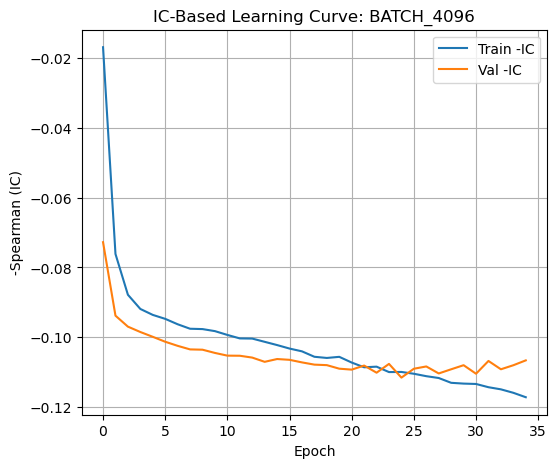

📊 Test IC: 0.0629 , p-value: 0.0


C:\Users\26954\AppData\Local\Temp\ipykernel_25644\1422460871.py:3: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

c:\Users\26954\anaconda3\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



Information Coefficient (Spearman rho): 0.06294679538145957
P-value: 2.5064110989909478e-39
NN_hedge sharpe: 1.1914743880816017, max_drawdown: -0.17360835461607832, annual return: 0.17301670730683172
NN_long sharpe: 0.32635465851047585, max_drawdown: -0.29595842049074506, annual return: 0.06305140220745396
NN_short sharpe: 0.46590115025752643, max_drawdown: -0.530467147517015, annual return: 0.10996530509937796

🚀 Running experiment: BATCH_512, hidden=(32, 32), alpha=0.0001, lr=0.001, batch=512
⛔ Early stopped at epoch 19


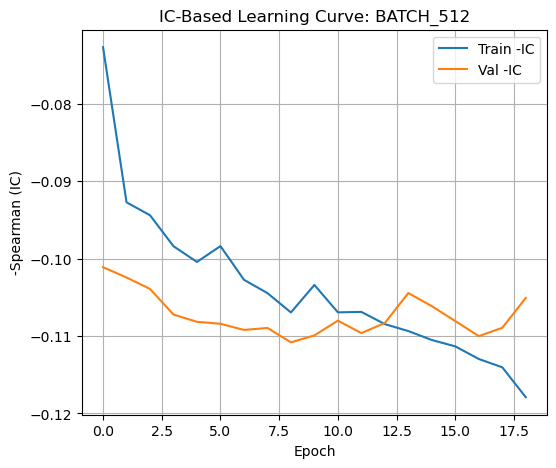

📊 Test IC: 0.0647 , p-value: 0.0


C:\Users\26954\AppData\Local\Temp\ipykernel_25644\1422460871.py:3: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

c:\Users\26954\anaconda3\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



Information Coefficient (Spearman rho): 0.06467317003118768
P-value: 2.0157188524905818e-41
NN_hedge sharpe: 0.9514023712237496, max_drawdown: -0.27358706587574994, annual return: 0.15189925296274565
NN_long sharpe: 0.2611753381235473, max_drawdown: -0.31805916506929244, annual return: 0.04971112788915785
NN_short sharpe: 0.4178638080104733, max_drawdown: -0.5782753757713367, annual return: 0.10218812507358774

🚀 Running experiment: EXPRESSIVE_LOWREG, hidden=(64, 32), alpha=1e-05, lr=0.001, batch=512
⛔ Early stopped at epoch 19


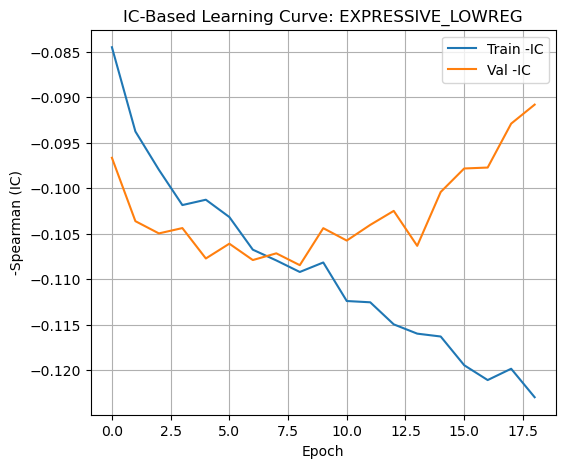

📊 Test IC: 0.0602 , p-value: 0.0


C:\Users\26954\AppData\Local\Temp\ipykernel_25644\1422460871.py:3: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

c:\Users\26954\anaconda3\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



Information Coefficient (Spearman rho): 0.060175675144029016
P-value: 4.397428703246681e-36
NN_hedge sharpe: 1.4606042073327148, max_drawdown: -0.16182357178067885, annual return: 0.19427014051989128
NN_long sharpe: 0.31992564216488667, max_drawdown: -0.31394621475965784, annual return: 0.062465273439645155
NN_short sharpe: 0.5773176647021402, max_drawdown: -0.4572631012957534, annual return: 0.13180486708024616

🚀 Running experiment: WIDE_STRONGREG_BIGBATCH, hidden=(128,), alpha=0.001, lr=0.001, batch=2048
⛔ Early stopped at epoch 30


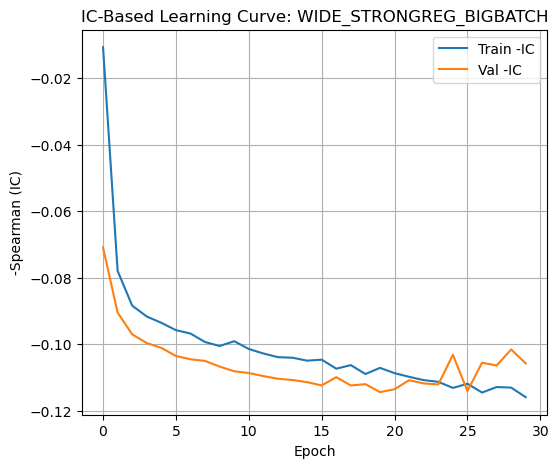

📊 Test IC: 0.0615 , p-value: 0.0


C:\Users\26954\AppData\Local\Temp\ipykernel_25644\1422460871.py:3: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

c:\Users\26954\anaconda3\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



Information Coefficient (Spearman rho): 0.061547408007183176
P-value: 1.1362879214850809e-37
NN_hedge sharpe: 1.2111106199192703, max_drawdown: -0.23917306632742905, annual return: 0.19349764360661403
NN_long sharpe: 0.3542540684444591, max_drawdown: -0.29445523049615935, annual return: 0.06568289564494846
NN_short sharpe: 0.5419706444787792, max_drawdown: -0.5069317966419887, annual return: 0.1278147479616653


In [ ]:
# === 执行扩展实验组 ===
for name, (arch, alpha, lr, batch) in new_architectures.items():
    run_experiment(name, hidden_layers=arch, alpha=alpha, lr=lr, batch_size=batch)

In [ ]:
nn_results_df

,name,arch,alpha,lr,batch,ic,pval,NN_hedge_sharpe,NN_hedge_max_dd,NN_hedge_returns,NN_hedge_cumulative_return,NN_long_sharpe,NN_long_max_dd,NN_long_returns,NN_long_cumulative_return,NN_short_sharpe,NN_short_max_dd,NN_short_returns,NN_short_cumulative_return
0,WIDE_32_32,"(32, 32)",0.000100,0.001000,1024,0.066484,0.000000,1.014703,-0.238347,0.159451,1.953134,0.278765,-0.316182,0.053909,0.352115,0.431091,-0.554456,0.105542,0.673238
1,WIDE_64_64,"(64, 64)",0.000100,0.001000,1024,0.063990,0.000000,1.267571,-0.168648,0.185206,2.575655,0.331273,-0.294540,0.061446,0.442869,0.519973,-0.466715,0.123761,0.924240
2,DEEP_64_64_32,"(64, 64, 32)",0.000100,0.001000,1024,0.063532,0.000000,1.345996,-0.150352,0.193288,2.795846,0.349241,-0.286611,0.068400,0.504676,0.536521,-0.440012,0.124887,0.944181
3,SHALLOW_32,"(32,)",0.000100,0.001000,1024,0.060809,0.000000,1.065358,-0.189561,0.165081,2.042525,0.277360,-0.298726,0.050628,0.335654,0.477393,-0.542738,0.114453,0.780372
4,REG_WEAK,"(32, 32)",0.000010,0.001000,1024,0.067293,0.000000,0.993827,-0.258908,0.159745,1.930470,0.277817,-0.314020,0.053839,0.350165,0.435796,-0.556470,0.105905,0.671503
5,REG_STRONG,"(32, 32)",0.001000,0.001000,1024,0.068341,0.000000,1.069386,-0.233352,0.167702,2.141393,0.338892,-0.307650,0.063543,0.465875,0.431432,-0.560474,0.104159,0.663471
6,LR_FAST,"(32, 32)",0.000100,0.005000,1024,0.064294,0.000000,1.096675,-0.184387,0.167110,2.113172,0.276126,-0.299028,0.052948,0.338974,0.467790,-0.538997,0.114163,0.774254
7,LR_SLOW,"(32, 32)",0.000100,0.000100,1024,0.065750,0.000000,1.176792,-0.225989,0.175633,2.296016,0.352472,-0.302943,0.065405,0.482076,0.457184,-0.518725,0.110228,0.717089
8,BATCH_4096,"(32, 32)",0.000100,0.001000,4096,0.062947,0.000000,1.191474,-0.173608,0.173017,2.317599,0.326355,-0.295958,0.063051,0.445005,0.465901,-0.530467,0.109965,0.764837
9,BATCH_512,"(32, 32)",0.000100,0.001000,512,0.064673,0.000000,0.951402,-0.273587,0.151899,1.695416,0.261175,-0.318059,0.049711,0.311785,0.417864,-0.578275,0.102188,0.581339
